In [41]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [43]:
class RNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        """Initialize RNN with better weight initialization"""
        self.Wxh = np.random.randn(hidden_size, input_size) / np.sqrt(input_size)
        self.Whh = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.Why = np.random.randn(output_size, hidden_size) / np.sqrt(hidden_size)
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.smooth_loss = -np.log(1.0 / output_size)
        
        self.training_history = {
            'loss': [],
            'accuracy': [],
            'predictions': [],
            'hidden_states': [],
            'confidence': []
        }

    def softmax(self, x):
        """Compute softmax with numerical stability"""
        x = x - np.max(x, axis=0)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=0)

    def forward(self, inputs, h_prev):
        """Forward pass with stable softmax"""
        self.x_states, self.h_states, self.y_states = {}, {}, {}
        self.h_states[-1] = np.copy(h_prev)
        
        for t in range(len(inputs)):
            self.x_states[t] = inputs[t].reshape(-1, 1)
            
            h_raw = np.dot(self.Wxh, self.x_states[t]) + \
                   np.dot(self.Whh, self.h_states[t-1]) + self.bh
            self.h_states[t] = np.tanh(h_raw)
            
            logits = np.dot(self.Why, self.h_states[t]) + self.by
            self.y_states[t] = self.softmax(logits)
        
        return self.y_states, self.h_states, self.x_states

    def backward(self, targets):
        """Compute gradients with proper scaling"""
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        dh_next = np.zeros((self.hidden_size, 1))
        
        for t in reversed(range(len(targets))):
            # Gradient on output probabilities
            dy = np.copy(self.y_states[t])
            dy[targets[t]] -= 1
            
            dWhy += np.dot(dy, self.h_states[t].T)
            dby += dy
            
            dh = np.dot(self.Why.T, dy) + dh_next
            dtanh = (1 - self.h_states[t] ** 2) * dh
            dbh += dtanh
            dWxh += np.dot(dtanh, self.x_states[t].T)
            dWhh += np.dot(dtanh, self.h_states[t-1].T)
            dh_next = np.dot(self.Whh.T, dtanh)
        
        for grad in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(grad, -5, 5, out=grad)
            
        return dWxh, dWhh, dWhy, dbh, dby

    def train_step(self, inputs, targets, h_prev):
        """Perform one training step with proper probability handling"""
        outputs, hidden_states, _ = self.forward(inputs, h_prev)
        
        total_loss = 0.0
        predictions = []
        confidences = []
        hidden_activations = []
        
        for t in range(len(targets)):
            prob = outputs[t][targets[t]]
            total_loss += -np.log(np.maximum(prob, 1e-10))
            
            pred = np.argmax(outputs[t])
            conf = float(np.max(outputs[t]))  
            
            predictions.append(pred)
            confidences.append(conf)
            hidden_activations.append(float(np.mean(np.abs(hidden_states[t]))))
        
        self.smooth_loss = 0.999 * self.smooth_loss + 0.001 * float(total_loss)
        accuracy = np.mean([p == t for p, t in zip(predictions, targets)])
        
        self.training_history['loss'].append(self.smooth_loss)
        self.training_history['accuracy'].append(accuracy)
        self.training_history['predictions'].append(predictions)
        self.training_history['confidence'].append(np.mean(confidences))
        self.training_history['hidden_states'].append(np.mean(hidden_activations))
        
        gradients = self.backward(targets)
        self.update_parameters(*gradients)
        
        return self.smooth_loss, hidden_states[len(inputs)-1]

    def update_parameters(self, dWxh, dWhh, dWhy, dbh, dby):
        """Update parameters with adaptive step sizes"""
        for param, dparam in [
            (self.Wxh, dWxh), 
            (self.Whh, dWhh),
            (self.Why, dWhy),
            (self.bh, dbh),
            (self.by, dby)
        ]:
            step = self.learning_rate * dparam
            param -= step

    def plot_training_progress(self):
        """Plot training metrics with improved visualization"""
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.plot(self.training_history['loss'], 'b-', label='Loss', linewidth=2)
        plt.title('Training Loss', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(self.training_history['accuracy'], 'g-', label='Accuracy', linewidth=2)
        plt.title('Model Accuracy', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(2, 2, 3)
        plt.plot(self.training_history['confidence'], color='orange', label='Confidence', linewidth=2)
        plt.title('Prediction Confidence', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Confidence')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(2, 2, 4)
        plt.plot(self.training_history['hidden_states'], color='purple', label='Activity', linewidth=2)
        plt.title('Hidden State Activity', fontsize=12)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Activation')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def predict(self, x, h):
        """Make a single prediction"""
        outputs, new_h, _ = self.forward([x], h)
        prediction = np.argmax(outputs[0])
        confidence = float(np.max(outputs[0]))
        return prediction, confidence, new_h[0]

    def print_prediction_analysis(self, inputs, targets, epoch):
        """Print detailed analysis"""
        h = np.zeros((self.hidden_size, 1))
        outputs, _, _ = self.forward(inputs, h)
        
        predictions = []
        confidences = []
        for t in range(len(targets)):
            pred = np.argmax(outputs[t])
            conf = float(np.max(outputs[t]))
            predictions.append(pred)
            confidences.append(conf)
        
        print(f"\nEpoch {epoch} Analysis:")
        print("-" * 50)
        print("Sample Predictions (First 10 sequences):")
        print(f"{'Index':^6} {'Target':^8} {'Predicted':^10} {'Correct':^8} {'Confidence':^12}")
        print("-" * 50)
        
        for i in range(min(10, len(targets))):
            correct = "✓" if predictions[i] == targets[i] else "✗"
            print(f"{i:^6d} {targets[i]:^8d} {predictions[i]:^10d} {correct:^8} {confidences[i]:^12.4f}")
        
        class_counts = np.bincount(predictions, minlength=self.output_size)
        total_preds = len(predictions)
        
        print("\nClass Distribution:")
        for i in range(self.output_size):
            percentage = (class_counts[i] / total_preds) * 100
            print(f"Class {i}: {percentage:.1f}% ({class_counts[i]} predictions)")
        
        accuracy = np.mean([p == t for p, t in zip(predictions, targets)])
        mean_confidence = np.mean(confidences)
        
        print("\nSummary Statistics:")
        print(f"Overall Accuracy: {accuracy:.2%}")
        print(f"Mean Confidence: {mean_confidence:.4f}")
        print(f"Current Loss: {self.smooth_loss:.2f}")

In [45]:
def create_toy_data(sequence_length=25, input_size=5):
    """Create sequential pattern data"""
    inputs = []
    targets = []
    
    for i in range(sequence_length):
        current_class = i % input_size
        next_class = (current_class + 1) % input_size
        
        input_vec = np.zeros(input_size)
        input_vec[current_class] = 1
        inputs.append(input_vec)
        targets.append(next_class)
    
    return inputs, targets

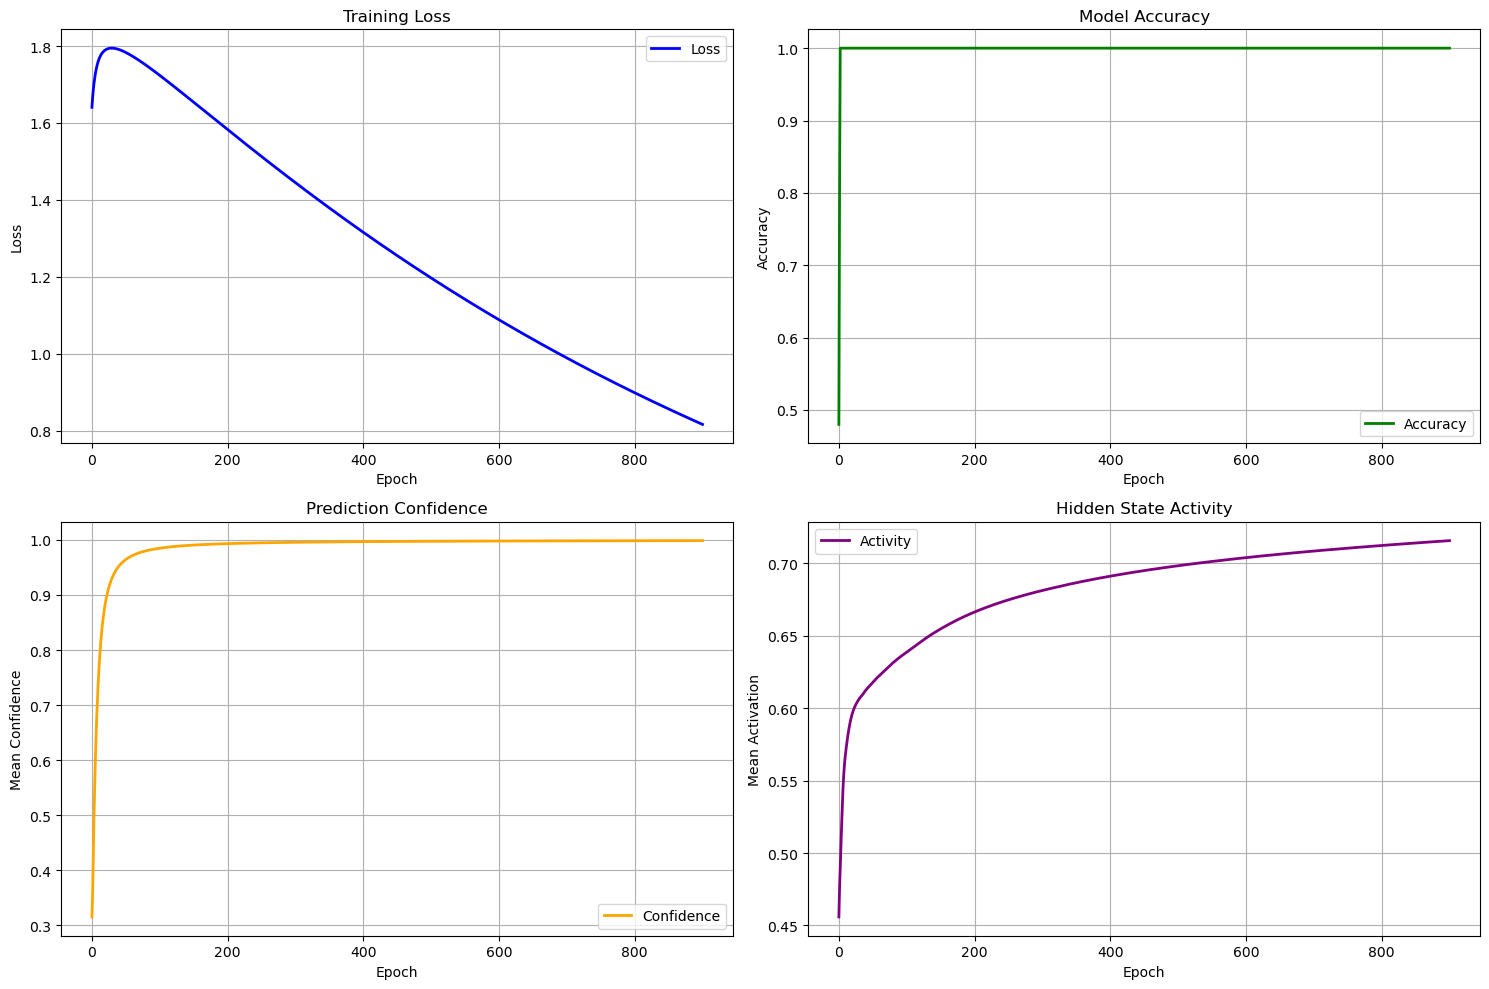


Epoch 900 Analysis:
--------------------------------------------------
Sample Predictions (First 10 sequences):
Index   Target  Predicted  Correct   Confidence 
--------------------------------------------------
  0       1         1         ✓        0.6622   
  1       2         2         ✓        0.9270   
  2       3         3         ✓        0.9879   
  3       4         4         ✓        0.9971   
  4       0         0         ✓        0.9983   
  5       1         1         ✓        0.9988   
  6       2         2         ✓        0.9985   
  7       3         3         ✓        0.9986   
  8       4         4         ✓        0.9986   
  9       0         0         ✓        0.9988   

Class Distribution:
Class 0: 20.0% (5 predictions)
Class 1: 20.0% (5 predictions)
Class 2: 20.0% (5 predictions)
Class 3: 20.0% (5 predictions)
Class 4: 20.0% (5 predictions)

Summary Statistics:
Overall Accuracy: 100.00%
Mean Confidence: 0.9818
Current Loss: 0.82


In [47]:
if __name__ == "__main__":
    input_size = 5
    hidden_size = 32
    output_size = 5
    learning_rate = 0.005
    
    rnn = RNN(input_size, hidden_size, output_size, learning_rate)
    
    inputs, targets = create_toy_data()
    
    print("Training Pattern (first 5 samples):")
    for i in range(5):
        input_class = np.argmax(inputs[i])
        print(f"Input {input_class} -> Target {targets[i]}")
    
    n_epochs = 1000
    h_prev = np.zeros((hidden_size, 1))
    
    for epoch in range(n_epochs):
        loss, h_prev = rnn.train_step(inputs, targets, h_prev)
        
        if epoch % 100 == 0:
            clear_output(wait=True)
            rnn.plot_training_progress()
            rnn.print_prediction_analysis(inputs, targets, epoch)
            plt.close()

In [55]:
import numpy as np

class LSTM:
    def __init__(self, input_size, hidden_size):
        """
        Initialize LSTM cell parameters
        
        Args:
            input_size: Size of input features
            hidden_size: Size of hidden state and cell state
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Initialize weights and biases
        # Weight matrices for input gate
        self.Wii = np.random.randn(hidden_size, input_size) / np.sqrt(input_size)
        self.Whi = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.bi = np.zeros((hidden_size, 1))
        
        # Weight matrices for forget gate
        self.Wif = np.random.randn(hidden_size, input_size) / np.sqrt(input_size)
        self.Whf = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.bf = np.zeros((hidden_size, 1))
        
        # Weight matrices for cell gate
        self.Wig = np.random.randn(hidden_size, input_size) / np.sqrt(input_size)
        self.Whg = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.bg = np.zeros((hidden_size, 1))
        
        # Weight matrices for output gate
        self.Wio = np.random.randn(hidden_size, input_size) / np.sqrt(input_size)
        self.Who = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.bo = np.zeros((hidden_size, 1))
        
        # Initialize gradients with proper shapes
        self.dWii = np.zeros_like(self.Wii)
        self.dWhi = np.zeros_like(self.Whi)
        self.dbi = np.zeros_like(self.bi)
        
        self.dWif = np.zeros_like(self.Wif)
        self.dWhf = np.zeros_like(self.Whf)
        self.dbf = np.zeros_like(self.bf)
        
        self.dWig = np.zeros_like(self.Wig)
        self.dWhg = np.zeros_like(self.Whg)
        self.dbg = np.zeros_like(self.bg)
        
        self.dWio = np.zeros_like(self.Wio)
        self.dWho = np.zeros_like(self.Who)
        self.dbo = np.zeros_like(self.bo)

    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        return x * (1 - x)
    
    def tanh_derivative(self, x):
        """Derivative of tanh function"""
        return 1 - x * x

    def forward(self, x, h_prev, c_prev):
        """
        Forward pass of LSTM
        
        Args:
            x: Input at current timestep (input_size, batch_size)
            h_prev: Previous hidden state (hidden_size, batch_size)
            c_prev: Previous cell state (hidden_size, batch_size)
            
        Returns:
            h: Current hidden state
            c: Current cell state
            cache: Cache for backward pass
        """
        # Ensure inputs have correct shape
        assert x.shape[0] == self.input_size
        assert h_prev.shape[0] == self.hidden_size
        assert c_prev.shape[0] == self.hidden_size
        
        # Input gate
        i = self.sigmoid(np.dot(self.Wii, x) + np.dot(self.Whi, h_prev) + self.bi)
        
        # Forget gate
        f = self.sigmoid(np.dot(self.Wif, x) + np.dot(self.Whf, h_prev) + self.bf)
        
        # Cell gate
        g = np.tanh(np.dot(self.Wig, x) + np.dot(self.Whg, h_prev) + self.bg)
        
        # Output gate
        o = self.sigmoid(np.dot(self.Wio, x) + np.dot(self.Who, h_prev) + self.bo)
        
        # Cell state
        c = f * c_prev + i * g
        
        # Hidden state
        h = o * np.tanh(c)
        
        # Cache for backward pass
        cache = (x, h_prev, c_prev, i, f, g, o, c)
        
        return h, c, cache

    def backward(self, dh, dc, cache):
        """
        Backward pass of LSTM
        
        Args:
            dh: Gradient of loss with respect to hidden state (hidden_size, batch_size)
            dc: Gradient of loss with respect to cell state (hidden_size, batch_size)
            cache: Cache from forward pass
            
        Returns:
            dx: Gradient with respect to input x
            dh_prev: Gradient with respect to previous hidden state
            dc_prev: Gradient with respect to previous cell state
        """
        x, h_prev, c_prev, i, f, g, o, c = cache
        batch_size = x.shape[1]
        
        # Gradient through tanh
        do = dh * np.tanh(c)
        dc = dc + dh * o * (1 - np.tanh(c) ** 2)
        
        # Gradient through cell state
        di = dc * g
        df = dc * c_prev
        dg = dc * i
        
        # Gradient through gates
        di = di * self.sigmoid_derivative(i)
        df = df * self.sigmoid_derivative(f)
        dg = dg * (1 - g ** 2)  # tanh derivative
        do = do * self.sigmoid_derivative(o)
        
        # Gradient with respect to weights
        self.dWii += np.dot(di, x.T)
        self.dWhi += np.dot(di, h_prev.T)
        self.dbi += np.sum(di, axis=1, keepdims=True)
        
        self.dWif += np.dot(df, x.T)
        self.dWhf += np.dot(df, h_prev.T)
        self.dbf += np.sum(df, axis=1, keepdims=True)
        
        self.dWig += np.dot(dg, x.T)
        self.dWhg += np.dot(dg, h_prev.T)
        self.dbg += np.sum(dg, axis=1, keepdims=True)
        
        self.dWio += np.dot(do, x.T)
        self.dWho += np.dot(do, h_prev.T)
        self.dbo += np.sum(do, axis=1, keepdims=True)
        
        # Gradient with respect to inputs
        dx = (np.dot(self.Wii.T, di) + np.dot(self.Wif.T, df) + 
              np.dot(self.Wig.T, dg) + np.dot(self.Wio.T, do))
        
        dh_prev = (np.dot(self.Whi.T, di) + np.dot(self.Whf.T, df) +
                  np.dot(self.Whg.T, dg) + np.dot(self.Who.T, do))
        
        dc_prev = dc * f
        
        return dx, dh_prev, dc_prev

    def update_params(self, learning_rate):
        """Update parameters using gradients and learning rate"""
        self.Wii -= learning_rate * self.dWii
        self.Whi -= learning_rate * self.dWhi
        self.bi -= learning_rate * self.dbi
        
        self.Wif -= learning_rate * self.dWif
        self.Whf -= learning_rate * self.dWhf
        self.bf -= learning_rate * self.dbf
        
        self.Wig -= learning_rate * self.dWig
        self.Whg -= learning_rate * self.dWhg
        self.bg -= learning_rate * self.dbg
        
        self.Wio -= learning_rate * self.dWio
        self.Who -= learning_rate * self.dWho
        self.bo -= learning_rate * self.dbo
        
        # Reset gradients
        self.dWii = np.zeros_like(self.Wii)
        self.dWhi = np.zeros_like(self.Whi)
        self.dbi = np.zeros_like(self.bi)
        
        self.dWif = np.zeros_like(self.Wif)
        self.dWhf = np.zeros_like(self.Whf)
        self.dbf = np.zeros_like(self.bf)
        
        self.dWig = np.zeros_like(self.Wig)
        self.dWhg = np.zeros_like(self.Whg)
        self.dbg = np.zeros_like(self.bg)
        
        self.dWio = np.zeros_like(self.Wio)
        self.dWho = np.zeros_like(self.Who)
        self.dbo = np.zeros_like(self.bo)

# Example usage
def example():
    # Initialize LSTM
    input_size = 10
    hidden_size = 20
    lstm = LSTM(input_size, hidden_size)
    
    # Sample input (input_size, batch_size)
    batch_size = 1
    x = np.random.randn(input_size, batch_size)
    h_prev = np.zeros((hidden_size, batch_size))
    c_prev = np.zeros((hidden_size, batch_size))
    
    # Forward pass
    h, c, cache = lstm.forward(x, h_prev, c_prev)
    
    # Sample gradient with correct shapes
    dh = np.random.randn(hidden_size, batch_size)
    dc = np.random.randn(hidden_size, batch_size)
    
    # Backward pass
    dx, dh_prev, dc_prev = lstm.backward(dh, dc, cache)
    
    # Update parameters
    learning_rate = 0.01
    lstm.update_params(learning_rate)
    
    return h, c, dx, dh_prev, dc_prev

if __name__ == "__main__":
    h, c, dx, dh_prev, dc_prev = example()
    print("Hidden state shape:", h.shape)
    print("Cell state shape:", c.shape)
    print("Input gradient shape:", dx.shape)
    print("Hidden state gradient shape:", dh_prev.shape)
    print("Cell state gradient shape:", dc_prev.shape)

Hidden state shape: (20, 1)
Cell state shape: (20, 1)
Input gradient shape: (10, 1)
Hidden state gradient shape: (20, 1)
Cell state gradient shape: (20, 1)


In [49]:
import numpy as np
from typing import List, Tuple, Dict
from collections import defaultdict

class SimpleLSTM:
    def __init__(self, input_size: int, hidden_size: int):
        # Architecture parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Small initial scale for better gradient flow
        self.scale = 0.01
        
        # Input gate
        self.Wii = np.random.randn(hidden_size, input_size) * self.scale
        self.Whi = np.random.randn(hidden_size, hidden_size) * self.scale
        self.bi = np.zeros((hidden_size, 1))
        
        # Forget gate
        self.Wif = np.random.randn(hidden_size, input_size) * self.scale
        self.Whf = np.random.randn(hidden_size, hidden_size) * self.scale
        self.bf = np.ones((hidden_size, 1))  # Initialize to 1 for better memory
        
        # Cell gate
        self.Wig = np.random.randn(hidden_size, input_size) * self.scale
        self.Whg = np.random.randn(hidden_size, hidden_size) * self.scale
        self.bg = np.zeros((hidden_size, 1))
        
        # Output gate
        self.Wio = np.random.randn(hidden_size, input_size) * self.scale
        self.Who = np.random.randn(hidden_size, hidden_size) * self.scale
        self.bo = np.zeros((hidden_size, 1))
        
        # Output projection
        self.Why = np.random.randn(input_size, hidden_size) * self.scale
        self.by = np.zeros((input_size, 1))
        
        # For tracking
        self.last_inputs = {}
        self.gates = {}

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        """Stable sigmoid"""
        return 1 / (1 + np.exp(-np.clip(x, -15, 15)))
    
    def tanh(self, x: np.ndarray) -> np.ndarray:
        """Stable tanh"""
        return np.tanh(np.clip(x, -15, 15))

    def forward(self, x: np.ndarray, h_prev: np.ndarray, c_prev: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, dict]:
        """Forward pass with minimal complexity"""
        eps = 1e-8
        
        # Ensure proper shapes and normalize input
        x = x / (np.sum(x) + eps)
        batch_size = x.shape[1]
        
        # Input gate
        i = self.sigmoid(
            np.dot(self.Wii, x) + 
            np.dot(self.Whi, h_prev) + 
            np.broadcast_to(self.bi, (self.hidden_size, batch_size))
        )
        
        # Forget gate
        f = self.sigmoid(
            np.dot(self.Wif, x) + 
            np.dot(self.Whf, h_prev) + 
            np.broadcast_to(self.bf, (self.hidden_size, batch_size))
        )
        
        # Cell gate
        g = self.tanh(
            np.dot(self.Wig, x) + 
            np.dot(self.Whg, h_prev) + 
            np.broadcast_to(self.bg, (self.hidden_size, batch_size))
        )
        
        # Output gate
        o = self.sigmoid(
            np.dot(self.Wio, x) + 
            np.dot(self.Who, h_prev) + 
            np.broadcast_to(self.bo, (self.hidden_size, batch_size))
        )
        
        # States
        c = f * c_prev + i * g
        c = np.clip(c, -5, 5)  # Prevent explosions
        h = o * self.tanh(c)
        
        # Output
        y = np.dot(self.Why, h) + np.broadcast_to(self.by, (self.input_size, batch_size))
        
        # Store for backward pass
        self.last_inputs = {
            'x': x, 'h_prev': h_prev, 'c_prev': c_prev,
            'i': i, 'f': f, 'g': g, 'o': o, 'c': c, 'h': h
        }
        
        return h, c, y

    def backward(self, dy: np.ndarray, dh_next: np.ndarray, dc_next: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Backward pass with gradient clipping"""
        # Get stored forward pass values
        x = self.last_inputs['x']
        h_prev = self.last_inputs['h_prev']
        c_prev = self.last_inputs['c_prev']
        i = self.last_inputs['i']
        f = self.last_inputs['f']
        g = self.last_inputs['g']
        o = self.last_inputs['o']
        c = self.last_inputs['c']
        h = self.last_inputs['h']
        
        batch_size = x.shape[1]
        
        # Initialize gradients
        self.dWhy = np.zeros_like(self.Why)
        self.dby = np.zeros_like(self.by)
        
        self.dWii = np.zeros_like(self.Wii)
        self.dWhi = np.zeros_like(self.Whi)
        self.dbi = np.zeros_like(self.bi)
        
        self.dWif = np.zeros_like(self.Wif)
        self.dWhf = np.zeros_like(self.Whf)
        self.dbf = np.zeros_like(self.bf)
        
        self.dWig = np.zeros_like(self.Wig)
        self.dWhg = np.zeros_like(self.Whg)
        self.dbg = np.zeros_like(self.bg)
        
        self.dWio = np.zeros_like(self.Wio)
        self.dWho = np.zeros_like(self.Who)
        self.dbo = np.zeros_like(self.bo)
        
        # Output gradients
        self.dWhy = np.dot(dy, h.T) / batch_size
        self.dby = np.sum(dy, axis=1, keepdims=True) / batch_size
        
        dh = np.dot(self.Why.T, dy) + dh_next
        
        # Gate gradients with clipping
        do = dh * self.tanh(c)
        do = do * o * (1 - o)
        
        dc = dh * o * (1 - self.tanh(c)**2) + dc_next
        dc = np.clip(dc, -5, 5)
        
        di = dc * g * i * (1 - i)
        df = dc * c_prev * f * (1 - f)
        dg = dc * i * (1 - g**2)
        
        # Input gradients
        self.dWii = np.dot(di, x.T) / batch_size
        self.dWhi = np.dot(di, h_prev.T) / batch_size
        self.dbi = np.sum(di, axis=1, keepdims=True) / batch_size
        
        self.dWif = np.dot(df, x.T) / batch_size
        self.dWhf = np.dot(df, h_prev.T) / batch_size
        self.dbf = np.sum(df, axis=1, keepdims=True) / batch_size
        
        self.dWig = np.dot(dg, x.T) / batch_size
        self.dWhg = np.dot(dg, h_prev.T) / batch_size
        self.dbg = np.sum(dg, axis=1, keepdims=True) / batch_size
        
        self.dWio = np.dot(do, x.T) / batch_size
        self.dWho = np.dot(do, h_prev.T) / batch_size
        self.dbo = np.sum(do, axis=1, keepdims=True) / batch_size
        
        # Previous step gradients
        dx = (np.dot(self.Wii.T, di) + np.dot(self.Wif.T, df) +
              np.dot(self.Wig.T, dg) + np.dot(self.Wio.T, do))
        
        dh_prev = (np.dot(self.Whi.T, di) + np.dot(self.Whf.T, df) +
                  np.dot(self.Whg.T, dg) + np.dot(self.Who.T, do))
        
        dc_prev = dc * f
        
        return dx, dh_prev, dc_prev

    def update_params(self, learning_rate: float) -> None:
        """Update parameters with gradient clipping"""
        # Clip gradients
        clip = lambda x: np.clip(x, -5, 5)
        
        # Update with clipped gradients
        self.Wii -= learning_rate * clip(self.dWii)
        self.Whi -= learning_rate * clip(self.dWhi)
        self.bi -= learning_rate * clip(self.dbi)
        
        self.Wif -= learning_rate * clip(self.dWif)
        self.Whf -= learning_rate * clip(self.dWhf)
        self.bf -= learning_rate * clip(self.dbf)
        
        self.Wig -= learning_rate * clip(self.dWig)
        self.Whg -= learning_rate * clip(self.dWhg)
        self.bg -= learning_rate * clip(self.dbg)
        
        self.Wio -= learning_rate * clip(self.dWio)
        self.Who -= learning_rate * clip(self.dWho)
        self.bo -= learning_rate * clip(self.dbo)
        
        self.Why -= learning_rate * clip(self.dWhy)
        self.by -= learning_rate * clip(self.dby)

class CharacterLSTM:
    def __init__(self, hidden_size: int):
        self.hidden_size = hidden_size
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0
        self.lstm = None
        self.loss_history = []

    def prepare_data(self, text: str) -> str:
        """Prepare data with minimal preprocessing"""
        # Basic text cleanup
        text = text.lower()  # Lowercase all text
        text = ' '.join(text.split())  # Normalize whitespace
        
        # Add start/end tokens
        text = "<s> " + text + " </s>"
        
        # Create vocabulary
        chars = sorted(list(set(text)))
        self.char_to_idx = {char: idx for idx, char in enumerate(chars)}
        self.idx_to_char = {idx: char for idx, char in enumerate(chars)}
        self.vocab_size = len(chars)
        
        # Initialize LSTM
        self.lstm = SimpleLSTM(self.vocab_size, self.hidden_size)
        
        return text

    def encode_sequence(self, sequence: str, batch_size: int) -> np.ndarray:
        """Convert sequence to one-hot encoded matrix"""
        x = np.zeros((self.vocab_size, batch_size))
        for i, char in enumerate(sequence):
            if i < batch_size:
                x[self.char_to_idx[char], i] = 1
        return x

    def train(self, text: str, seq_length: int, num_epochs: int, learning_rate: float, 
             batch_size: int = 32) -> List[float]:
        """Train with curriculum learning"""
        # Prepare data
        text = self.prepare_data(text)
        
        # Curriculum learning parameters
        initial_seq_length = 5  # Start with very short sequences
        final_seq_length = seq_length
        min_lr = learning_rate * 0.1
        
        for epoch in range(num_epochs):
            # Adjust sequence length and learning rate
            progress = epoch / num_epochs
            current_seq_length = int(initial_seq_length + (final_seq_length - initial_seq_length) * progress)
            current_lr = max(min_lr, learning_rate * (1 - 0.9 * progress))
            
            epoch_loss = 0
            num_batches = 0
            
            # Create sequences
            for pos in range(0, len(text) - current_seq_length - 1, batch_size):
                # Get batch of sequences
                batch_sequences = []
                batch_targets = []
                
                for b in range(batch_size):
                    if pos + b < len(text) - current_seq_length - 1:
                        seq = text[pos + b:pos + b + current_seq_length]
                        target = text[pos + b + 1:pos + b + current_seq_length + 1]
                        batch_sequences.append(seq)
                        batch_targets.append(target)
                
                if not batch_sequences:
                    continue
                
                actual_batch_size = len(batch_sequences)
                
                # Initialize states
                h = np.zeros((self.hidden_size, actual_batch_size))
                c = np.zeros((self.hidden_size, actual_batch_size))
                
                batch_loss = 0
                dh_next = np.zeros_like(h)
                dc_next = np.zeros_like(c)
                
                # Forward through sequence
                for t in range(current_seq_length):
                    # Prepare input and target
                    x = self.encode_sequence([seq[t] for seq in batch_sequences], actual_batch_size)
                    targets = [seq[t] for seq in batch_targets]
                    
                    # Forward pass
                    h, c, y = self.lstm.forward(x, h, c)
                    
                    # Compute softmax and loss
                    max_y = np.max(y, axis=0, keepdims=True)
                    exp_y = np.exp(y - max_y)
                    probs = exp_y / np.sum(exp_y, axis=0, keepdims=True)
                    
                    # Cross entropy loss
                    for i, target in enumerate(targets):
                        target_idx = self.char_to_idx[target]
                        batch_loss -= np.log(probs[target_idx, i] + 1e-8)
                    
                    # Backward pass
                    dy = probs.copy()
                    for i, target in enumerate(targets):
                        target_idx = self.char_to_idx[target]
                        dy[target_idx, i] -= 1
                    
                    dx, dh_next, dc_next = self.lstm.backward(dy, dh_next, dc_next)
                
                # Update parameters
                self.lstm.update_params(current_lr)
                
                # Accumulate loss
                epoch_loss += batch_loss / (current_seq_length * actual_batch_size)
                num_batches += 1
                
                # Generate sample occasionally
                if num_batches % 100 == 0:
                    sample = self.generate_text(
                        seed_text="The ",
                        length=50,
                        temperature=0.7
                    )
                    print(f"\nSample (epoch {epoch+1}, batch {num_batches}):")
                    print(sample)
            
            # Record average loss
            avg_loss = epoch_loss / num_batches
            self.loss_history.append(avg_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, "
                  f"Loss: {avg_loss:.4f}, "
                  f"Sequence Length: {current_seq_length}, "
                  f"Learning Rate: {current_lr:.6f}")
        
        return self.loss_history

    def generate_text(self, seed_text: str, length: int, temperature: float = 0.7) -> str:
        """Generate text with nucleus sampling"""
        # Initialize states
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))
        
        # Process seed text
        generated = seed_text
        for char in seed_text:
            x = np.zeros((self.vocab_size, 1))
            x[self.char_to_idx[char.lower()]] = 1
            h, c, _ = self.lstm.forward(x, h, c)
        
        # Generate new characters
        for _ in range(length):
            x = np.zeros((self.vocab_size, 1))
            x[self.char_to_idx[generated[-1].lower()]] = 1
            
            h, c, y = self.lstm.forward(x, h, c)
            
            # Apply temperature
            y = y / temperature
            exp_y = np.exp(y - np.max(y))
            probs = exp_y / np.sum(exp_y)
            
            # Nucleus sampling (top-p)
            sorted_probs = np.sort(probs.ravel())[::-1]
            cumsum = np.cumsum(sorted_probs)
            cutoff = sorted_probs[np.argmax(cumsum > 0.9)]
            probs[probs < cutoff] = 0
            probs = probs / np.sum(probs)
            
            # Sample next character
            idx = np.random.choice(self.vocab_size, p=probs.ravel())
            next_char = self.idx_to_char[idx]
            
            # Stop if we hit the end token
            if next_char == "</s>":
                break
                
            generated += next_char
        
        return generated


def create_training_text() -> str:
    """Create simple, repetitive training text"""
    base_texts = [
        "The quick brown fox jumps over the lazy dog.",
        "Hello world, how are you today?",
        "To be, or not to be, that is the question.",
        "All that glitters is not gold.",
        "Actions speak louder than words.",
        "A journey of a thousand miles begins with a single step.",
        "Early bird catches the worm.",
        "Time flies like an arrow.",
        "Practice makes perfect.",
        "Knowledge is power."
    ]
    
    # Create variations
    variations = []
    for text in base_texts:
        text = text.lower()
        variations.append(text)
        words = text.split()
        if len(words) > 5:
            # Add partial sentences
            variations.append(" ".join(words[:len(words)//2]) + ".")
            variations.append(" ".join(words[len(words)//2:]) + ".")
            # Add variations with different word orders
            variations.append(" ".join(words[1:] + [words[0]]) + ".")
    
    # Repeat and shuffle
    all_text = variations * 20
    np.random.shuffle(all_text)
    return " ".join(all_text)


def main():
    # Set random seed
    np.random.seed(42)
    
    # Create training text
    text = create_training_text()
    
    # Create and train model
    model = CharacterLSTM(
        hidden_size=128  # Start with smaller hidden size
    )
    
    print("Training LSTM...")
    losses = model.train(
        text=text,
        seq_length=25,
        num_epochs=50,
        learning_rate=0.002,  # Lower learning rate
        batch_size=32
    )
    
    # Generate samples
    print("\nFinal samples:")
    
    print("\nConservative (temperature=0.5):")
    print(model.generate_text("The ", 100, temperature=0.5))
    
    print("\nBalanced (temperature=0.7):")
    print(model.generate_text("The ", 100, temperature=0.7))
    
    print("\nCreative (temperature=1.0):")
    print(model.generate_text("The ", 100, temperature=1.0))


if __name__ == "__main__":
    main()

Training LSTM...

Sample (epoch 1, batch 100):
The hwfermhimjexlaadzx..gkeohme.prjveqmhco?rb fu ,l on

Sample (epoch 1, batch 200):
The ciraojhfmdp?vsibhqg.?qvusszamdcifpie.dkopcii wppnj

Sample (epoch 1, batch 300):
The chbucd hrblyjttpgsyeknnim,,xmbdrqpdu,isdd kxlxchzt

Sample (epoch 1, batch 400):
The n.?jusvinfmolbgonj,jmc lhq?mwxwtyzekrlxzkfiqrhv? z
Epoch 1/50, Loss: 3.4757, Sequence Length: 5, Learning Rate: 0.002000

Sample (epoch 2, batch 100):
The xeyfklolxm by,sz vr nxjsfhq rdvmeqxlvxhutm,t,yj cc

Sample (epoch 2, batch 200):
The v,agbbcao,gpfgstsflwid ncr.ifez.  .vanos??f.eniefc

Sample (epoch 2, batch 300):
The jjwpodfvmbr,wmze.kmsnhbwfcdm ttwu.la.  g i?uhojjje

Sample (epoch 2, batch 400):
The ?wsd l.reni.z xqmu ?nlmvpgoqb kqvnnlxvlqpdczusxrte
Epoch 2/50, Loss: 3.4360, Sequence Length: 5, Learning Rate: 0.001964

Sample (epoch 3, batch 100):
The lifsjxhiw ldipoffgrj?xfjlres sable?axraty.rdlc?muy

Sample (epoch 3, batch 200):
The tdo?h?sas.mb?iy.i.cdktft ,ajgrztuzjynp jzxhm